# SMAI Assignment - 3

## Question - `2` : Gaussian Mixture Models

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

Resources: 
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html 

- A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 
- One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

There are, however, a couple of advantages to using Gaussian mixture models over k-means.
- k-means does not account for variance(width of the bell shape curve). In multiple dimensions, covariance matrix determines the shape of the distribution.
- K-means performs hard classification whereas GMM performs soft classification, i.e. in k-means, data point is deterministically assigned to one and only one cluster, but in reality there may be overlapping between the cluster GMM provide us the probabilities of the data point belonging to each of the possible clusters.

![GMM](./extras/gmm.png)

In [ ]:
#when using colab and uploading data as Data.zip 
!unzip Data.zip Data/*; mv Data/* .; rm -r Data

Archive:  Data.zip
   creating: Data/extras/
  inflating: Data/extras/gmm.png     
  inflating: Data/extras/gmm_plot.png  
  inflating: Data/extras/segmentation_reference.png  
  inflating: Data/extras/traffic_reference.gif  
   creating: Data/frames/
   creating: Data/images/
  inflating: Data/images/plant_cells.jpg  
  inflating: Data/images/plant_cells_2.jpeg  
   creating: Data/results/
   creating: Data/videos/
  inflating: Data/videos/pedestrian.avi  
  inflating: Data/videos/traffic.gif  
mv: cannot move 'Data/extras' to './extras': Directory not empty
mv: cannot move 'Data/images' to './images': Directory not empty
mv: cannot move 'Data/videos' to './videos': Directory not empty


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False, save_name=None):
    eps = 0.0001
    
    img = img.astype(np.float64)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + eps)
    
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    fig.tight_layout()
    
    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')
    
    if save:
        if save_name is None:
            save_name = title
            
        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

# GMM Implementation

- The main difficulty in learning Gaussian mixture models from unlabeled data is that one usually doesn’t know which points came from which latent component (if one has access to this information it gets very easy to fit a separate Gaussian distribution to each set of points). 
- Expectation-maximization (EM) is a well-founded statistical algorithm to get around this problem. (EM) algorithm is an iterative method to find (local) maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables.
- The EM iteration alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.
-  Repeating this process is guaranteed to always converge to a local optimum.

![GMM](./extras/gmm_plot.png)

Some details: 
- The choice of initialization is left upto you:
    - You can use `sklearn` libraries to assist you in initializing the means (eg. KMeans, Random, etc.)
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

class GMM:
  def __init__(self, K=1, tol=1e-3, max_iter=100):
    self.weights=None
    self.means=None
    self.covariances=None
    self.K=K
    self.max_iter= max_iter
    self.tol=tol
    self.e=1e-15

  def init_param(self, X, kmeans =False):
    self.weights=np.ones(self.K) / self.K
    self.covariances= np.array([ np.eye(X.shape[1]) for i in range(self.K) ])
    if kmeans:
      km=KMeans(n_clusters=self.K).fit(X)
      self.means =km.cluster_centers_
    else:
      self.means=np.random.randn(self.K, X.shape[1])

  def fit(self, X, kmeans=False):
    self.init_param(X, kmeans=True)
    prev_likelihood=0
    for i in range(self.max_iter):
      try:
        rsp=self.E(X)
      except:
        break
      curr_likelihood =np.sum(np.log(self.e+np.sum(rsp, axis=1)))
      try:
        self.M(X, rsp)
      except:
        break
      if abs(curr_likelihood - prev_likelihood) < self.tol:
        break
      prev_likelihood=curr_likelihood      

  def E(self, X):
    rsp=np.zeros( (X.shape[0], self.K))
    for k in range(self.K):
      rsp[:, k]=multivariate_normal.pdf(X, self.means[k], self.covariances[k], allow_singular=True)*self.weights[k]
    rsp /= rsp.sum(axis= 1, keepdims= True)+self.e
    return rsp
 
  def M(self, X, rsp):
    r_sum=rsp.sum(axis=0)
    self.weights=r_sum / X.shape[0]
    self.means=np.dot(rsp.T, X) / r_sum[:, None]
    for k in range(self.K):
      diff=X-self.means[k]
      self.covariances[k] =np.dot(rsp[:, k] *diff.T, diff)/ r_sum[k]
    
  def predict(self, X):
    P=np.zeros( (X.shape[0], self.K) )
    for i in range(self.K):
      P[:, i] = multivariate_normal.pdf(X, self.means[i], self.covariances[i], allow_singular=True)
    weighted_p=P* self.weights
    label=np.argmax(weighted_p, axis=1)
    return label
  def score_samples(self, X):
    P=np.zeros( (X.shape[0], self.K) )
    for i in range(self.K):
      P[:, i] = multivariate_normal.pdf(X, self.means[i], self.covariances[i], allow_singular=True)
    return P*self.weights


# Semantic Segmentation

- Semantic segmentation, or image segmentation, is the task of clustering parts of an image together which belong to the same object class. 
- It is a form of pixel-level prediction because each pixel in an image is classified according to a category.

(Note: The label texts on the image are not part of the expected output)

![SS](./extras/segmentation_reference.png)

## Unsupervised 

- One of the most popular and unsupervised way to perform Semantic Segmentation on unlabelled data is clustering
- In this section we are going to compare different clustering methods by selecting different number of components for each and visualizing.
- We can treat our Image as a distribution in the RGB space (or Grayscale/Intensity depending on your approach) and each pixel would act as a data point for the distribution.
- Using GMMs we would learn the nature of the distribution.
- Similar to K-Means we would assign the label to each pixel based on the weighted log-probabilities with each Gaussian.

In [ ]:
source_folder = './images'
img_name = 'plant_cells_2.jpeg'

img_path = f'{source_folder}/{img_name}'

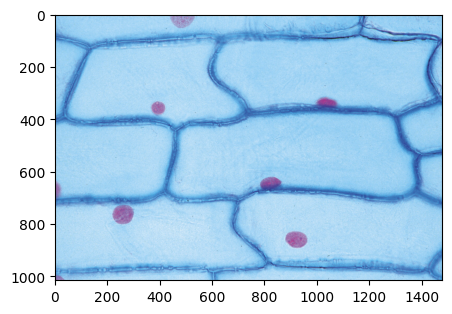

In [ ]:
test_img = cv2.imread(img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plot_rgb(test_img, figsize=(5, 5))

## Fit your GMM Model to the Image
- Fit the given image to your GMM model for different number of `components` / `clusters` / `gaussians`. (At least 3)
- You could also use different images from the `images` folder, but make sure to use that image for visualizations and predictions.

In [ ]:
"""
Create and Fit Multiple GMMs corresponding to different number of components
"""
image1 = cv2.imread("/content/images/plant_cells_2.jpeg")
image2 = cv2.imread("/content/images/plant_cells.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
X1 = image1.reshape(-1, 3)
X2 = image2.reshape(-1, 3)

img1_models = []
img2_models = []
for k in [1, 3, 5, 7, 10]:
  model = GMM(K=k)
  model.fit(X1, True)
  img1_models.append(model)

  model = GMM(K=k)
  model.fit(X2, True)
  img2_models.append(model)

## Predict and Visualize Segmented Maps

- Based on your fitted model, predict the label for each pixel
    - Here, by label we mean which `gaussian` / `component` the pixel belongs to.
- Below you have been given a reference code for plotting segmentation maps. You can implement your own function, but just make sure segmented maps are clearly visible and distinct.
- You are expected to visualize the segmentation maps for multiple values of `components` and observe the differences (at least 3)

In [ ]:
def plot_seg(img, figsize=None, cmap=None, title=None, xlabel=None, ylabel=None, save=False, save_name=None):
    """
    Funciton for Plotting Segmentation Maps.
    Expected Input: 2D Matrix of the size of the image containing just label values (1, 2, 3, ...) instead of [R, G, B] / Grayscale values.
    """
    
    img = np.copy(img)
    n_class = np.max(img) + 1 ## Could remove +1 depending on how you constructed segmented maps
    
    colors = []
    for i in range(n_class):
        colors.append(( np.random.randint(256), np.random.randint(256), np.random.randint(256)))
    
    colors = np.asarray(colors, dtype=np.uint8)
    
    
    fig = plt.figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    fig.tight_layout()
    
    img = colors[img]
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')
    
    if save:
        if save_name is None:
            save_name = title
            
        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')
    
    plt.imshow(img, cmap=cmap)
    plt.show()

    plt.close(fig)

In [ ]:
"""
Predict the Labels for each pixel to get segmentation maps corresponding to different number of components
"""
pred_1 =[]
pred_2 =[]
for k in range(5):
  pred_1.append(img1_models[k].predict(X1).reshape(image1.shape[:2]))
  pred_2.append(img2_models[k].predict(X2).reshape(image2.shape[:2]))
print(len(pred_1), len(pred_2))

5 5


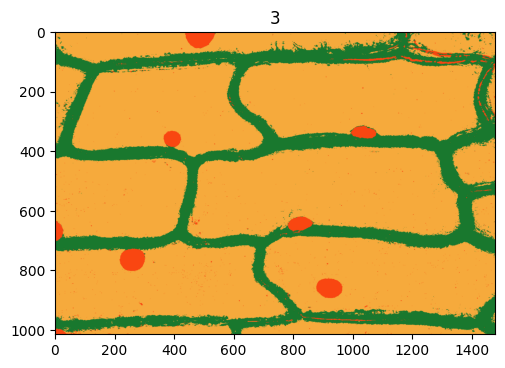

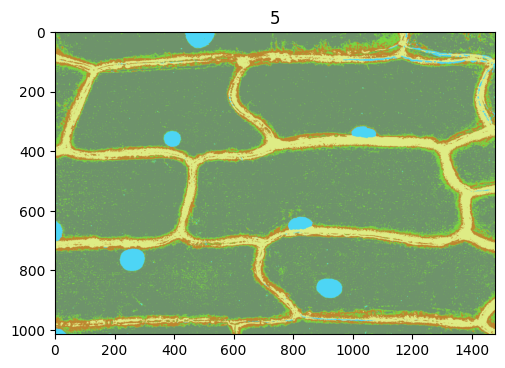

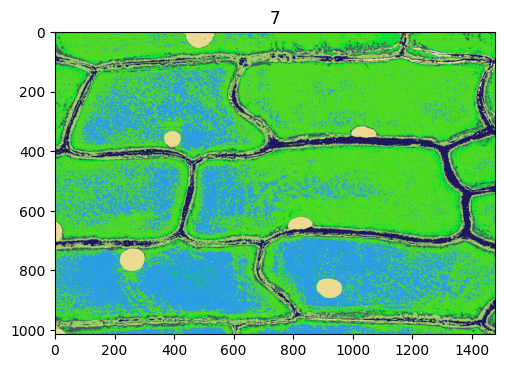

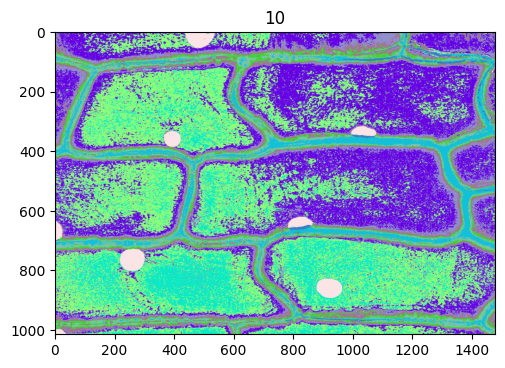

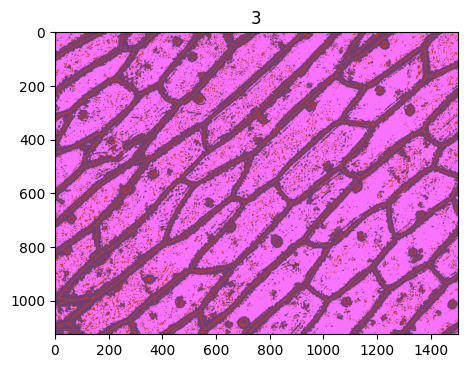

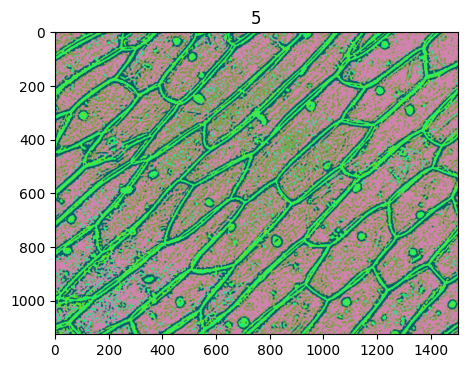

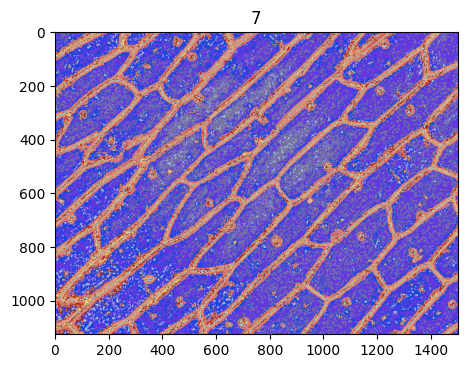

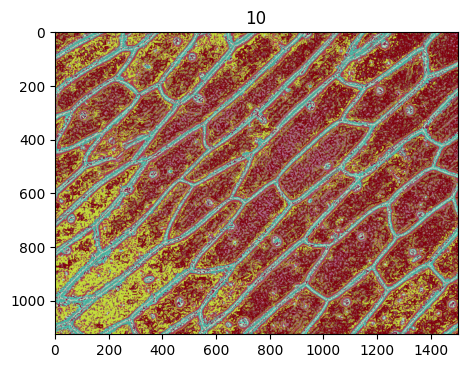

In [ ]:
"""
Visualize the segmentation maps using given helper function
"""
ks=[1, 3, 5, 7, 10]
for i in range(1, 5):
  plot_seg(pred_1[i], title=str(ks[i]))
for i in range(1, 5):
  plot_seg(pred_2[i], title=str(ks[i]))

## Use KMeans for Comparison

- Perform the same experiment with K-Mean Clustering using `sklearn.cluster.KMeans` and compare the result

In [ ]:
"""
Your code here
"""
from sklearn.cluster import KMeans

pred_1 = []
pred_2 = []
for k in [1, 3, 5, 7, 10]:
  model = KMeans(n_clusters=k)
  model.fit(X1, True)
  pred_1.append(model.predict(X1).reshape(image1.shape[:2]))

  model = KMeans(n_clusters=k)
  model.fit(X2, True)
  pred_2.append(model.predict(X2).reshape(image2.shape[:2]))

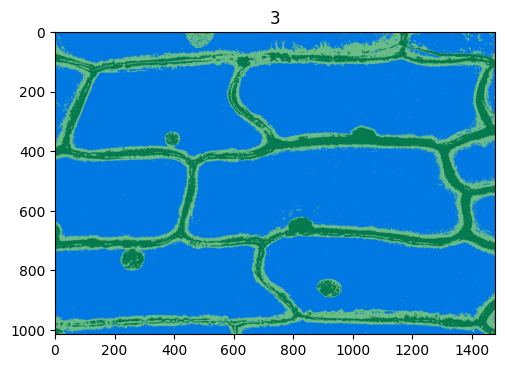

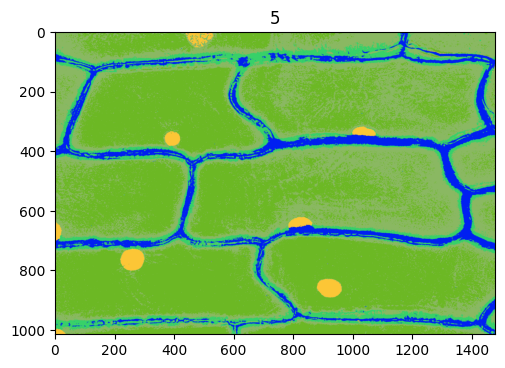

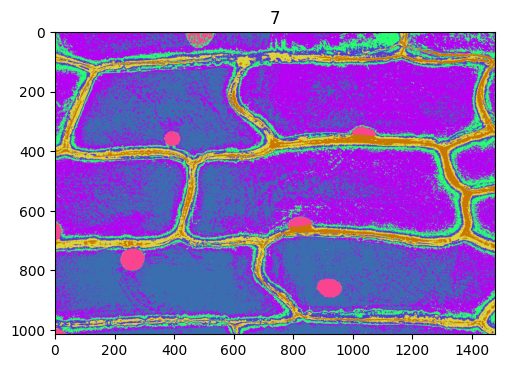

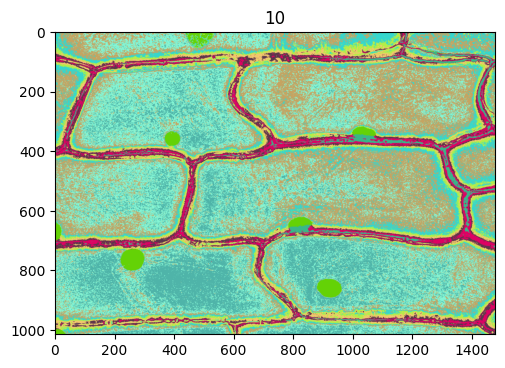

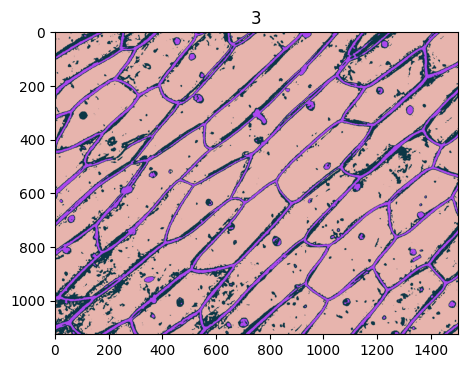

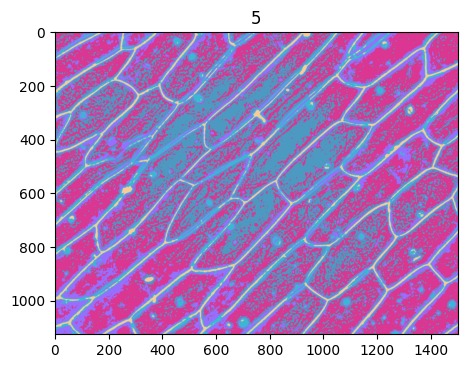

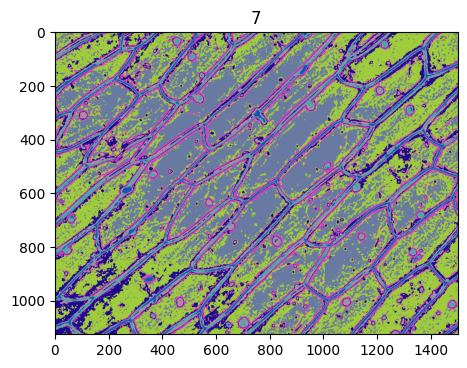

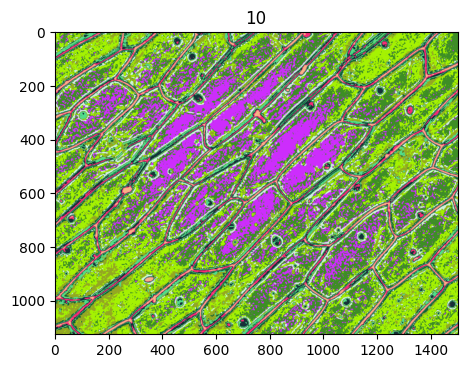

In [ ]:
ks=[1, 3, 5, 7, 10]
for i in range(1, 5):
  plot_seg(pred_1[i], title=str(ks[i]))
for i in range(1, 5):
  plot_seg(pred_2[i], title=str(ks[i]))

# Background Subtraction

- Foreground detection is one of the major tasks in the field of computer vision and image processing, whose aim is to detect changes in image sequences. 
- Background subtraction is any technique which allows an image's foreground to be extracted for further processing (object recognition, etc.).

One of the most important applications of this is Foreground Detection on Highways for speeding vehicles. 
Before the Deep Learning age, methods using GMMs were considered very effective in accurately detecting vehicles on highways. 

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly. As you can see one of the drawbacks of simply doing this is that changing environments and lighting would severly affect this method, so we are also going to explore Adaptive GMM which takes care of such problems.

(Note: The Segmentation GIF show below is a reference for the expected output, and since it is extracted just from the test frames, it is not in sync with the full GIF given above, so don't be confused)

(Another Note: The Segmentation GIF displays everything that is not the background, i.e. foreground objects, in White, and not just the white cars.)

![reference](./extras/traffic_reference.gif)

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Hint: Most of the time, the Gaussian with the higher weight corresponds to the background.
    - Hint-2: We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to (baseline - 1).
    To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    This method is much simpler to implement but, this could give worse results.
    
3. K-Means Per Pixel:
    - Similar approach to GMMs per pixel.

4. Adaptive GMM Per Pixel (Not part of the assignment):
    - We can update GMMs without fitting them for every subsequent frame.
    - The biggest advantage of this method is that it can be used in real time tracking and will also adapt to change in environments and lighting.
    - Note: This is not part of the assignment, only meant for enthusiasts who want to explore.

### Extracting Frames from videos

In [ ]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [ ]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

### Loading Frames

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)

### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

# train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=True, random_state=1)
train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


## 1. Frame Averaging

### Extract Background Image from the training data

In [ ]:
"""
You code here
"""
avg = np.zeros(frames[0].shape)
for frame in train_frames:
  avg+=frame
avg/=train_frames.shape[0]

In [ ]:
"""
Your code here
"""
bg_img = avg*255.0

### Visualize 

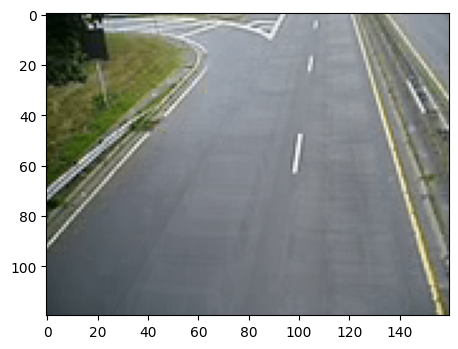

In [ ]:
"""
You code here
"""
plot_rgb(bg_img)

In [ ]:
"""
Your code here
"""

'\nYour code here\n'

## 2. GMMs per pixel

### Create Set of GMMs for every pixel and fit them considering every training frame

In [ ]:
"""
Your code here
"""
dim = train_frames.shape
N = dim[1]*dim[2]
flat_images = train_frames.reshape(dim[0], N, dim[3])
print(flat_images.shape)
models = []
for i in range(N):
  model=GMM(K=2, tol=1e-5)
  model.fit(flat_images[:,i], True)
  models.append(model)

(48, 19200, 3)


### Extract Background Image from the trained model

In [ ]:
"""
Your code here
"""
bg_pixels = np.asarray([models[i].means[np.argmax(models[i].weights)] for i in range(N)])
print(bg_pixels.shape)
bg_pixels = bg_pixels.reshape(dim[1], dim[2], 3)
print(bg_pixels.shape)


(19200, 3)
(120, 160, 3)


### Visualize 

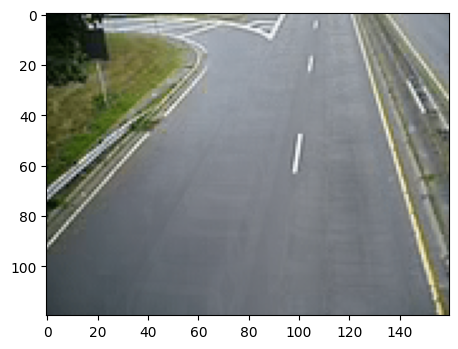

In [ ]:
"""
Your code here
"""
bg_image = bg_pixels*255
plot_rgb(bg_image)

## 3. Extracting Background using K-Means

- You can use `sklearn.cluster.KMeans` for this classification

### Create Set of K-Means for every pixel and fit them considering every training frame

In [ ]:
"""
Your code here
"""
from sklearn.cluster import KMeans
dim = train_frames.shape
N = dim[1]*dim[2]
flat_images = train_frames.reshape(dim[0], N, dim[3])
print(flat_images.shape)
knn_models = []
for i in range(N):
  model=KMeans(n_clusters = 2)
  model.fit(flat_images[:,i])
  knn_models.append(model)

(48, 19200, 3)


### Extract Background Image from the trained model

In [ ]:
"""
Your code here
"""
bg_index = []
for i in range(N):
  labels = knn_models[i].labels_
  bg_index.append(1 if (labels == 1).sum() > (labels == 0).sum() else 0) # cluster with more points will be background
knn_bg_pixels = np.asarray([knn_models[i].cluster_centers_[bg_index[i]] for i in range(N)])
print(knn_bg_pixels.shape)
knn_bg_pixels = knn_bg_pixels.reshape(dim[1], dim[2], 3)
print(knn_bg_pixels.shape)

(19200, 3)
(120, 160, 3)


### Visualize 

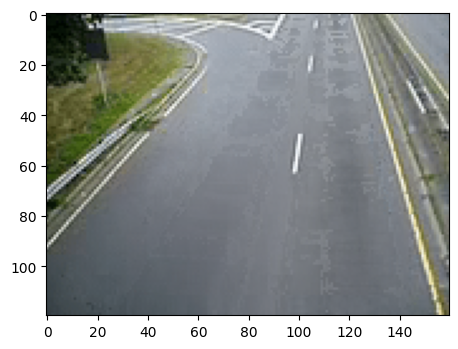

In [ ]:
"""
Your code here
"""
knn_bg_image = knn_bg_pixels*255
plot_rgb(knn_bg_image)

## Test

- Test the model / approach with the training frames
- You may use any approach that you prefer to achieve background subtraction"
    - Using the corresponding background image extracted earlier. (Bit more efficient but worse visualization)
    - Having per pixel predictions for every subsequent frame using your model. (Less efficient but better visualization)
- You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

### Displaying frames as videos

In [ ]:
def display_frames(frames, fps=10.0):
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()

### Saving frames as videos

In [ ]:
def save_frames(frames, fps=10.0, output_path='./results', file_name='temp', repeat=1):
    eps = 0.0001
    
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    # save_path = os.path.join(output_path, f"{file_name.rsplit('.')[0]}.avi")
    
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for r in range(repeat):
      for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        # cv2.imshow('frame',frame)
        # if cv2.waitKey(wait_time) & 0xFF == ord('q'):
        #     break
        
        vid_wrt.write(frame)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

### 1. Frame Averaging

In [ ]:
t_dim = test_frames.shape
N=t_dim[1]*t_dim[2]
subtracted_frames = np.zeros((t_dim[0], N, 3))
flat_test_images = test_frames.reshape(t_dim[0], N, t_dim[3])
bg= bg_pixels.reshape(N, 3)
for i in range(N):
  subtracted_frames[:, i] = flat_test_images[:, i] - bg[i]
subtracted_frames = subtracted_frames.reshape(t_dim)

In [ ]:
gray = np.asarray([np.sum(frame, axis=2) for frame in subtracted_frames])
gray*=255
# print(gray)
gray[gray > 70] = 255
gray[gray <= 70] =0
# gray

In [ ]:
gray.shape

(32, 120, 160)

In [ ]:
save_frames(subtracted_frames*255, file_name='sub_color', repeat = 4)
save_frames(gray, file_name='sub_gray', repeat = 4)

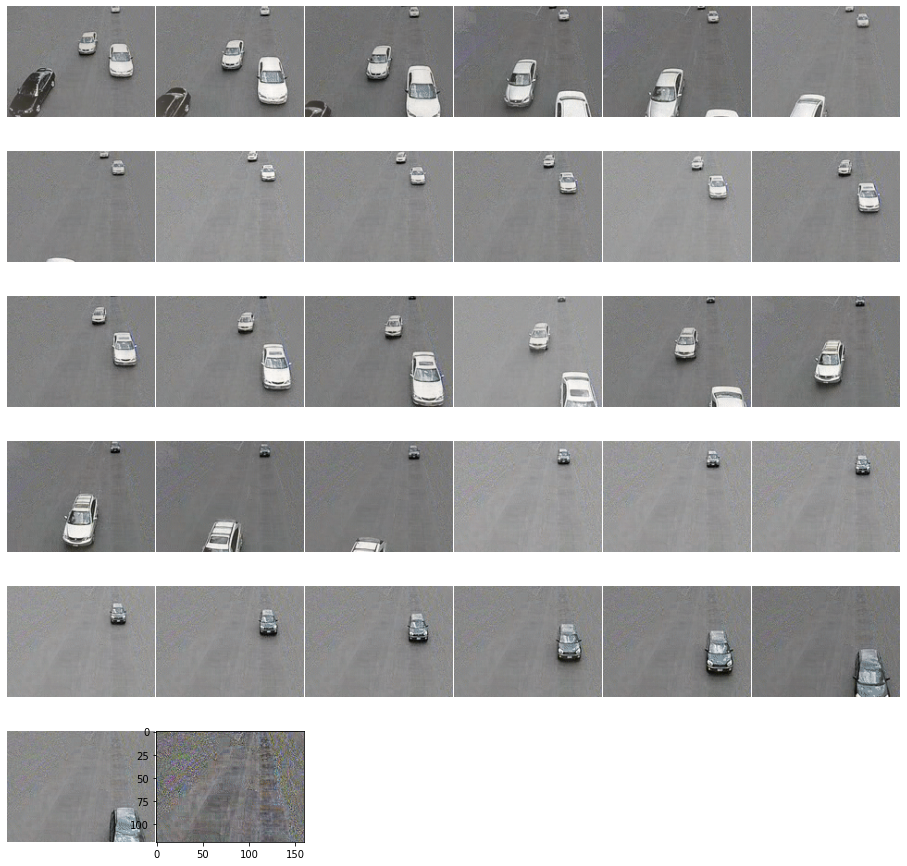

In [ ]:
subtracted_frames*=255
plt.figure(figsize=(16, 16))
for i, frame in enumerate(subtracted_frames):
  frame = ((frame - frame.min()) * 255 / (frame.max() - frame.min())).astype(np.int64)
  plt.axis('off')
  plt.subplot(6, 6, i+1)
  plt.imshow(frame)
plt.subplots_adjust(wspace=.01, hspace=0)
plt.show()

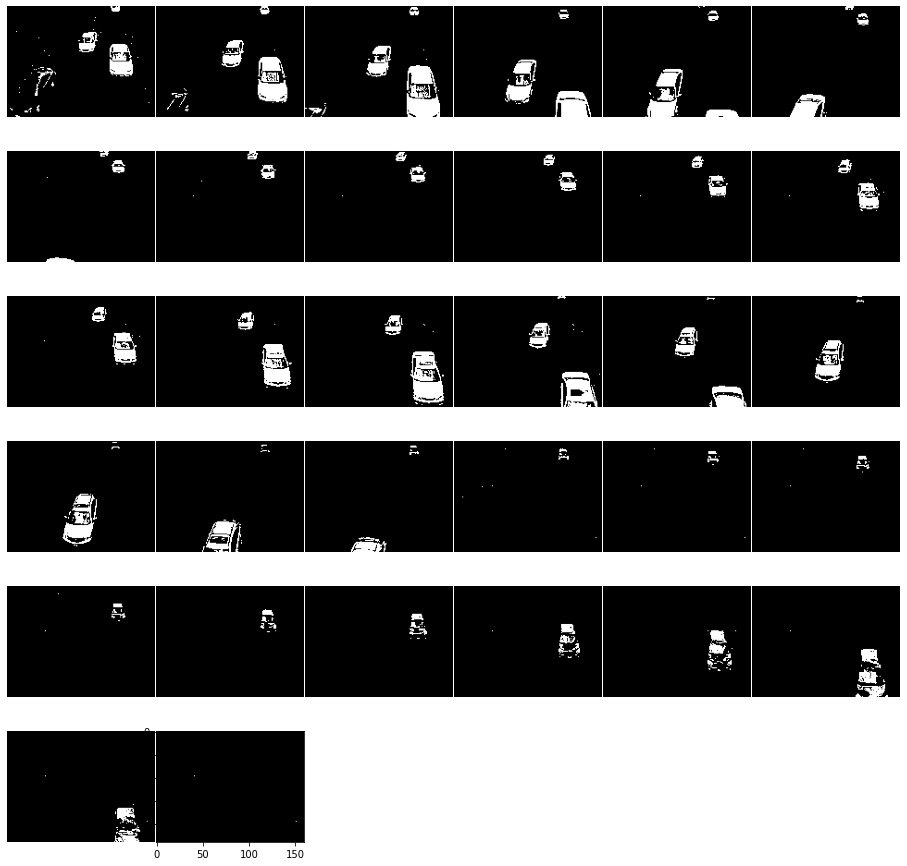

In [ ]:
plt.figure(figsize=(16, 16))
for i, frame in enumerate(gray):
  frame = ((frame - frame.min()) * 255 / (frame.max() - frame.min())).astype(np.int64)
  plt.axis('off')
  plt.subplot(6, 6, i+1)
  plt.imshow(frame, cmap='Greys_r')
plt.subplots_adjust(wspace=.01, hspace=0)
plt.show()

### 2. GMMs per pixel

In [ ]:
"""
Your code here
"""

t_dim = test_frames.shape
N=t_dim[1]*t_dim[2]
predicted_frames = np.zeros((t_dim[0], N))
flat_test_images = test_frames.reshape(t_dim[0], N, t_dim[3])
for i in range(N):
  bg_index = np.argmax(models[i].weights)
  fg_index = 1 - bg_index
  likelihood = models[i].score_samples(flat_test_images[:, i])
  likelihood = (likelihood - np.min(likelihood))/(np.max(likelihood)-np.min(likelihood))
  predicted_frames[:, i] = 255 * (likelihood[:,fg_index] > likelihood[:,bg_index])
  
predicted_frames = predicted_frames.reshape(t_dim[:-1])

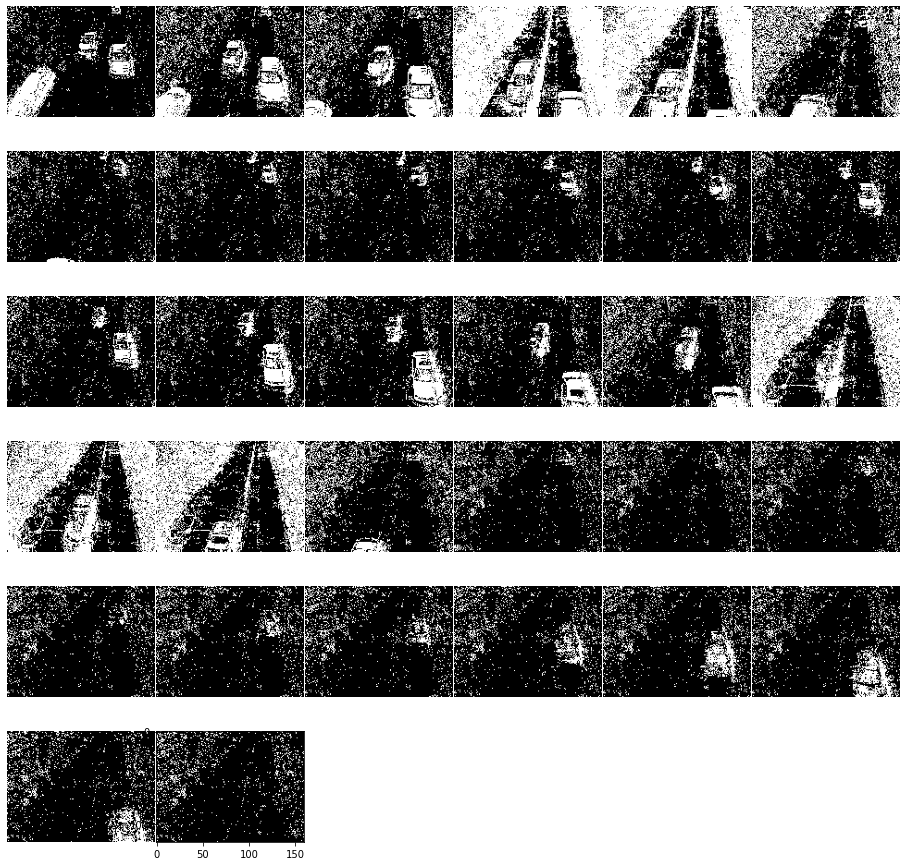

In [ ]:
plt.figure(figsize=(16, 16))
for i, frame in enumerate(predicted_frames):
  plt.axis('off')
  plt.subplot(6, 6, i+1)
  plt.imshow(frame, cmap='Greys_r')
plt.subplots_adjust(wspace=.01, hspace=0)
plt.show()

### 3. KMeans per pixel

- You can use `sklearn.cluster.KMeans` for this classification

In [ ]:
"""
Your code here
"""
t_dim = test_frames.shape
N=t_dim[1]*t_dim[2]
predicted_frames = np.zeros((t_dim[0], N))
flat_test_images = test_frames.reshape(t_dim[0], N, t_dim[3])
for i in range(N):
  labels = knn_models[i].labels_
  bg_index = 1 if (labels == 1).sum() > (labels == 0).sum() else 0
  pred = knn_models[i].predict(flat_test_images[:, i])
  predicted_frames[:, i] = 255 * (pred != bg_index)
  
predicted_frames = predicted_frames.reshape(t_dim[:-1])

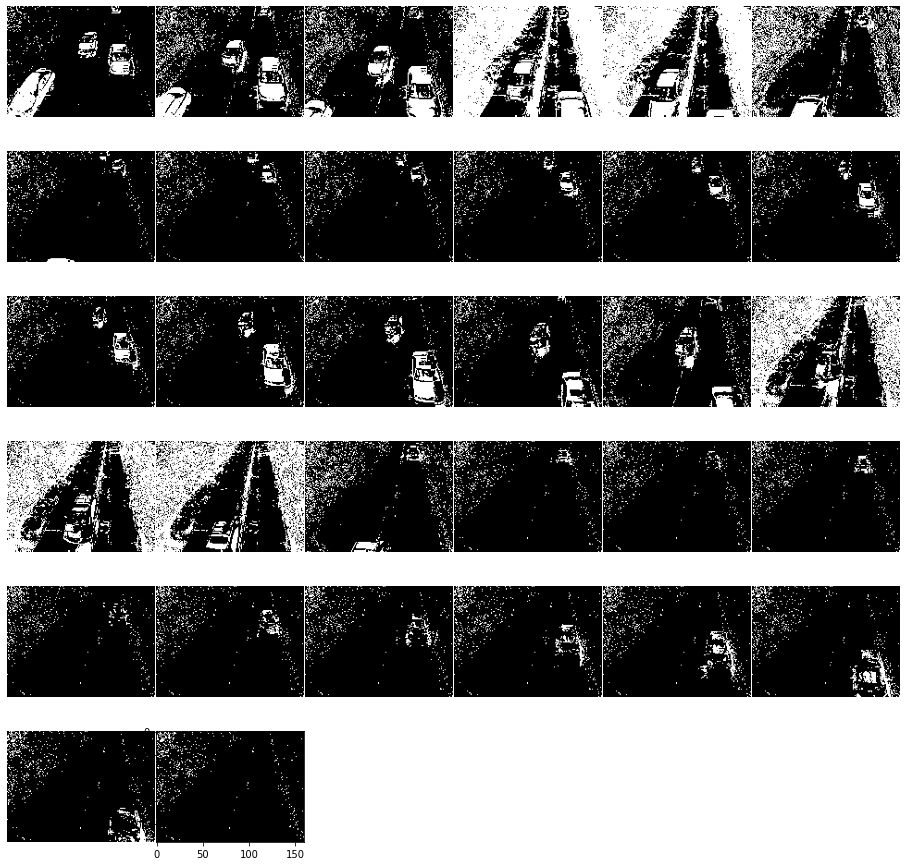

In [ ]:
plt.figure(figsize=(16, 16))
for i, frame in enumerate(predicted_frames):
  plt.axis('off')
  plt.subplot(6, 6, i+1)
  plt.imshow(frame, cmap='Greys_r')
plt.subplots_adjust(wspace=.01, hspace=0)
plt.show()

## 4. Adaptive (Not part of the assignment)
- Reference Paper: http://www.ai.mit.edu/projects/vsam/Publications/stauffer_cvpr98_track.pdf
- Video: https://youtu.be/0nz8JMyFF14
- This part is just for enthusiasts who want to explore some stuff.

In [ ]:
"""
Your code here
"""